## Diversity Sampling of Wikipedia Articles

This notebook provides a demo of the Coreset sampler, applied to text embeddings. 
The coreset algorithm iteratively samples the furthest texts to all the previously sampled texts, ensuring diversity.




**Notes**: We recommend running it on GPU. If you don't have access to a GPU, subsampling the data will be necessary



## Initialization

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 1000)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

In [2]:
try:
    import cuml
except ImportError:
    raise ImportError('Install RAPIDS cuml to ensure DBScan is fast enough !')

In [3]:
import torch
assert torch.cuda.is_available()  # Code is faster on GPU !

In [4]:
import sys
sys.path.append('../src/')

from coreset import CoresetSampler
from plot import plot_dbscan_results, plot_coreset_results

### Retrieve data

The dataset is a preprocessed subset from [here](https://www.kaggle.com/datasets/narek1110/wikipedia-22-12-en-embeddings-all-minilm-l6-v2). 
It is available [on Kaggle](https://www.kaggle.com/datasets/theoviel/diversity-sampling-demo-data/). Make sure you have downloaded the data and put it in the `input` folder.

- **df.parquet** : contains articles & associated metadata
    - `id`: article id
    - `title`: Title of the article
    - `text`: First paragraph of the article.
    - `url`: Url of the article
    - `domain`: Predicted domain by [this 10-class](https://huggingface.co/jonaskoenig/topic_classification_04) classifier.
    - `bertopic_class`: Predict class by [BERTopic](https://huggingface.co/MaartenGr/BERTopic_Wikipedia)
- **embeds.npy** : Embeddings assoaited to the `text` column, computed using [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

In [9]:
df = pd.read_parquet('/root/.cache/kagglehub/datasets/theoviel/diversity-sampling-demo-data/versions/1/df.parquet')
print(f"Retrieved {len(df)} articles")

Retrieved 486826 articles


In [10]:
df.head()

,id,title,text,url,domain,bertopic_class
0,30802348,Roman Catholic Diocese of Facatativá,The Roman Catholic Diocese of Facatativá () is a diocese located in the northwest of Cundinamarca Department in Colombia. Its see is the city of Facatativá; the diocese is part of the ecclesiastical province of Bogotá in Colombia.,https://en.wikipedia.org/wiki?curid=15894889,Society & Culture,2366_ecumenical_orthodox_catholic_ecclesiastical
1,30802349,1970 Japan Soccer League,"The 1970 season of the Japan Soccer League was the sixth season of Japanese league football. Toyo Industries won their fifth title and set the record for title wins, but they would not regain the title during the rest of the JSL's existence and would not win the successor league, the J. League Division 1, until 2012.",https://en.wikipedia.org/wiki?curid=15798791,Sports,0_goalscorer_scored_goals_goal
2,30802350,1909 Australasian Championships,"The 1909 Australasian Championships was a tennis tournament that took place on outdoor grass courts at Perth Zoo, Perth, Australia from 16 October to 25 October 1909. It was the fifth edition of the Australasian Championships (now known as the Australian Open), the first held in Perth and the third Grand Slam tournament of the year. Anthony Wilding won the singles title, his second after 1906.",https://en.wikipedia.org/wiki?curid=10978717,Sports,340_tennis_tournaments_tournament_badminton
3,30802351,Friedrich Bürklein,Georg Friedrich Christian Bürklein (30 March 1813 – 4 December 1872) was a German architect and a pupil of Friedrich von Gärtner.,https://en.wikipedia.org/wiki?curid=10690028,Education & Reference,223_nouveau_paintings_designers_façades
4,30802352,"Rodri (footballer, born 1979)","Rodrigo Gimeno Molina (born 21 September 1979), commonly known as Rodri, is a Spanish retired footballer who played mainly as a defensive midfielder.",https://en.wikipedia.org/wiki?curid=2656139,Sports,55_candidacy_candidate_candidates_presidential


In [11]:
embeds = np.load('/root/.cache/kagglehub/datasets/theoviel/diversity-sampling-demo-data/versions/1/embeds.npy')
print(f"Embedding shape: {embeds.shape}")

Embedding shape: (486826, 384)


In [12]:
sample_indices = np.random.choice(embeds.shape[0], size=1000, replace=False)

# Extract the samples
sampled_embeds = embeds[sample_indices]

In [13]:
print(f"Sampled Embedding shape: {sampled_embeds.shape}")

Sampled Embedding shape: (1000, 384)


In [5]:
embeds = np.load("/home/Diversity-Sampling/image_embeddings.npy")
image_ids = np.load("/home/Diversity-Sampling/image_ids.npy")
image_paths = np.load("/home/Diversity-Sampling/image_paths.npy")

In [6]:
print(f"Embedding shape: {embeds.shape}")
print(f"IDs shape: {image_ids.shape}")
print(f"image_paths shape: {image_paths.shape}")

Embedding shape: (1072, 768)
IDs shape: (1072,)
image_paths shape: (1072,)


### Coreset Sampler

The class `CoresetSampler` defined in `coreset.py` does all the heavy lifting !

I also define some parameters:
- `EPS`, `MIN_SAMPLES` are DBScan initialization parameters that work well for the provided data. 
- `N_SAMPLES` is the number of points we want to sample with coreset.

In [7]:
EPS = 0.9 # Higher eps = bigger clusters
MIN_SAMPLES = 3
N_SAMPLES = 100

In [8]:
coreset = CoresetSampler(
    n_samples=N_SAMPLES,
    initialization="dbscan",
    dbscan_params={"eps": EPS, "min_samples": MIN_SAMPLES},
    tqdm_disable=False,
    verbose=1,
)

Initializing with DBScan


### DBScan Initialization

We run DBScan clustering and analyze the results.

It takes about 1 minute to run DBScan on our data, thanks to RAPIDS cuml.

In [9]:
%%time
init_ids = coreset.initialize(embeds)

Initialize with 14 points
CPU times: user 95.4 ms, sys: 163 ms, total: 259 ms
Wall time: 258 ms


In [10]:
y = coreset.dbscan_y
counts = np.bincount(y + 1)

In [11]:
print('Number of clusters :', len(counts) - 1)
print('Number of non-clustered prompts :', counts[0])

Number of clusters : 14
Number of non-clustered prompts : 804


In [12]:
biggest = np.argsort(counts[1:])[::-1] # [:10]
sizes = np.sort(counts[1:])[::-1]
print('Biggest clusters :\t', list(biggest[:10]))
print('Associated sizes :\t', list(sizes[:10]))

Biggest clusters :	 [1, 5, 3, 0, 13, 2, 12, 10, 8, 11]
Associated sizes :	 [165, 41, 17, 7, 6, 5, 4, 4, 4, 3]


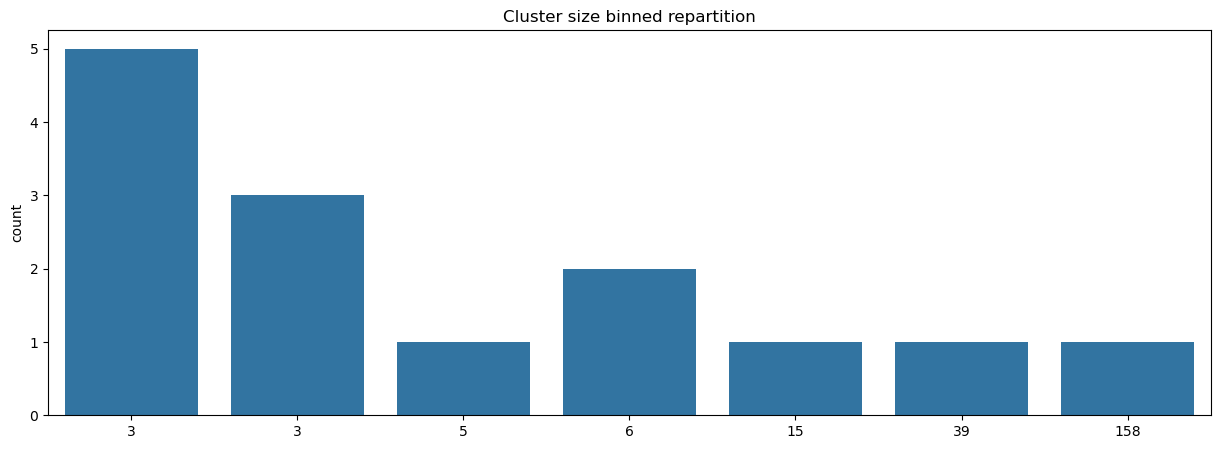

In [13]:
plt.figure(figsize=(15, 5))
sns.countplot(x=np.round(np.log10(np.clip(counts[1:], 0, 10000)), 1))
ticks, labels = plt.xticks()
labels = [float(l.get_text()) for l in labels]
plt.xticks(ticks, (10 ** np.array(labels)).astype(int))
plt.title('Cluster size binned repartition')
plt.show()

/opt/conda/envs/rapids-24.10/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


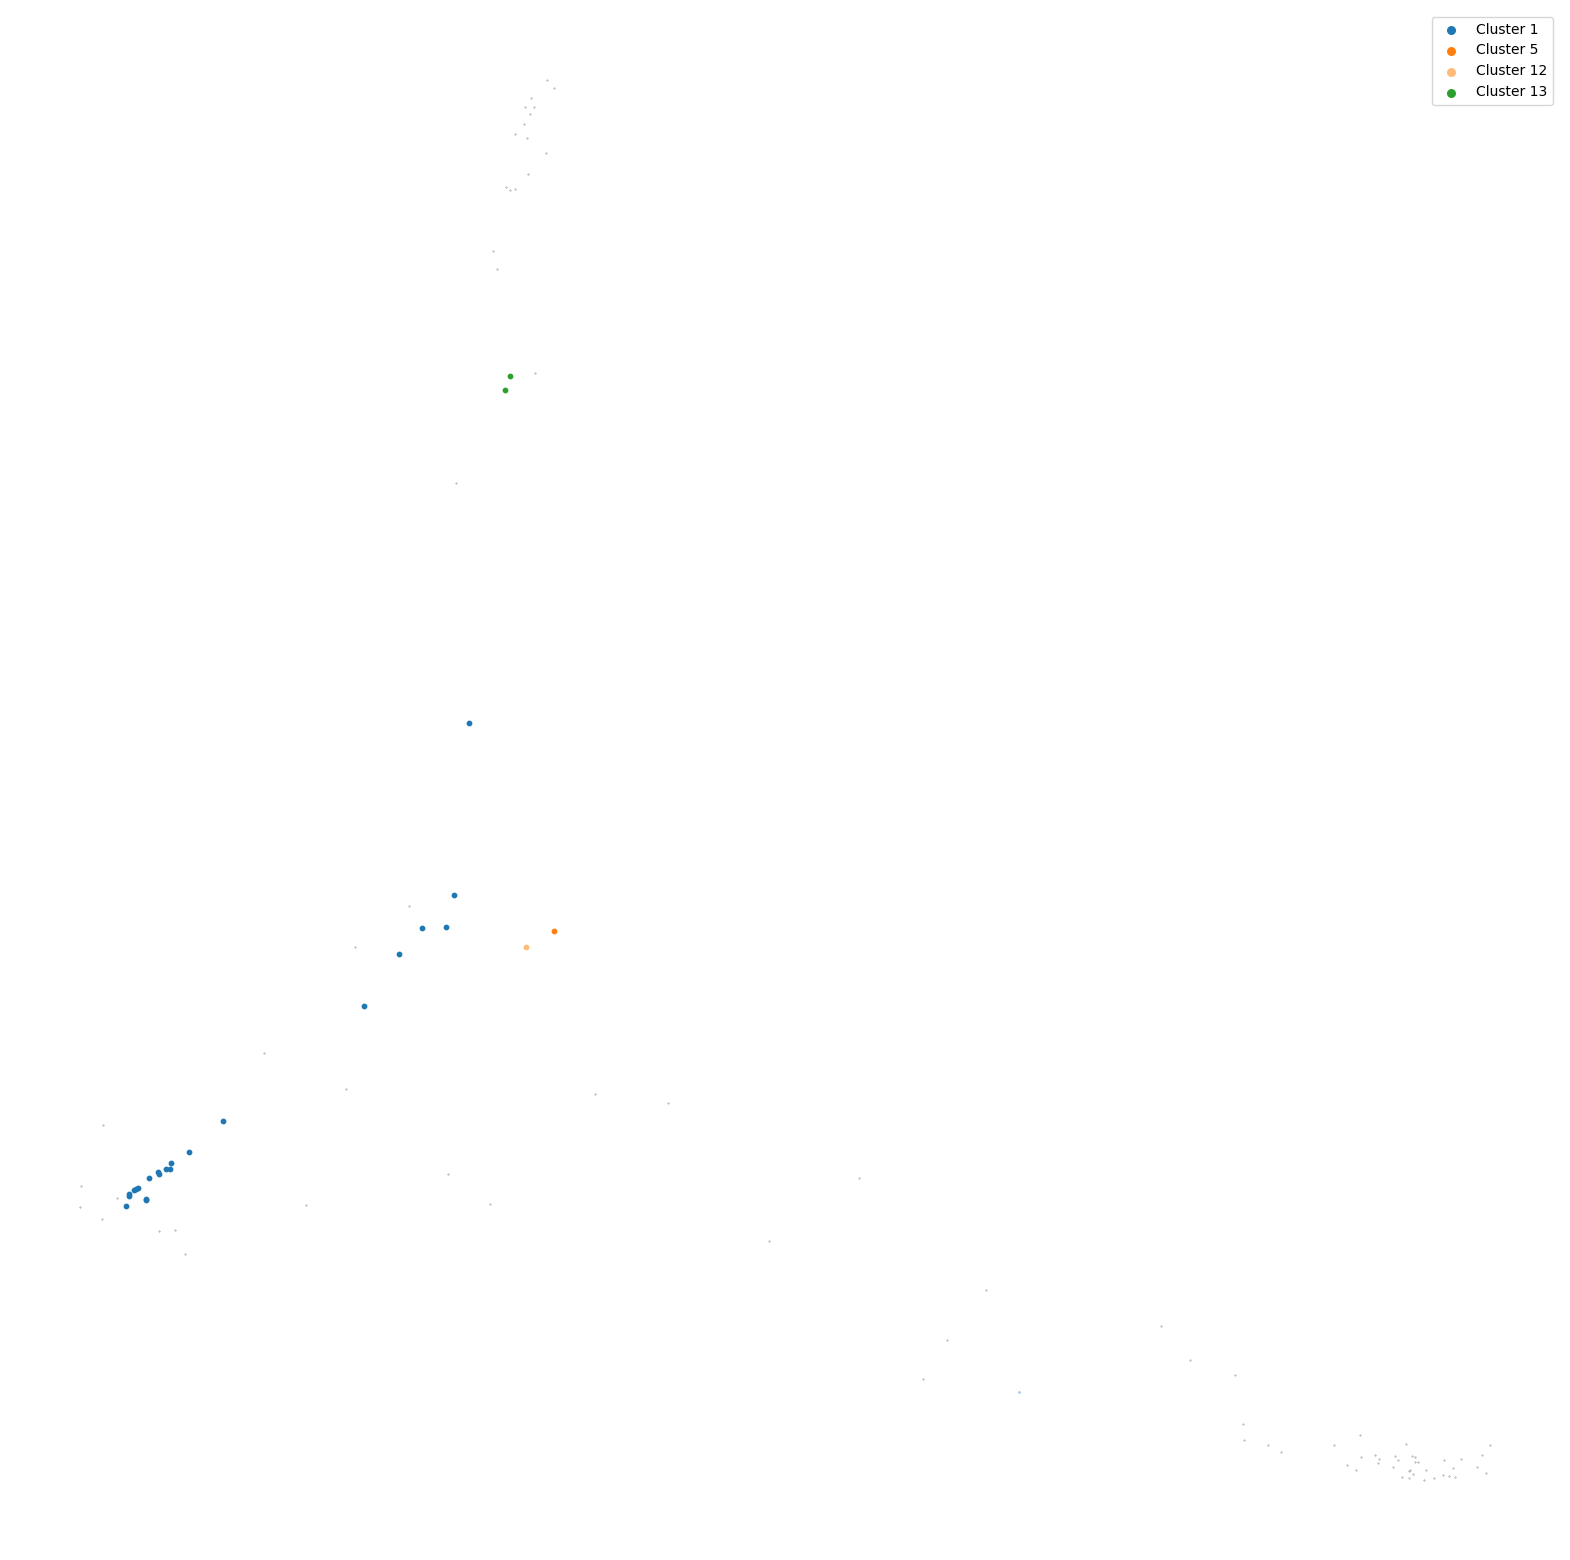

In [14]:
plot_dbscan_results(
    embeds, 
    y,
    counts,
    min_size=MIN_SAMPLES, 
    tsne_params=dict(perplexity=10, early_exaggeration=10),
)

The `plot_dbscan_results` function uses t-SNE to visualize DBScan results. Clusters are highlighted and outliers are in gray. 
The sampler will initialize using one random point per cluster.

We display below are a sample of the 10 biggest clusters :

Cluster id: 1
Cluster size: 165
Sample Images in this Cluster:


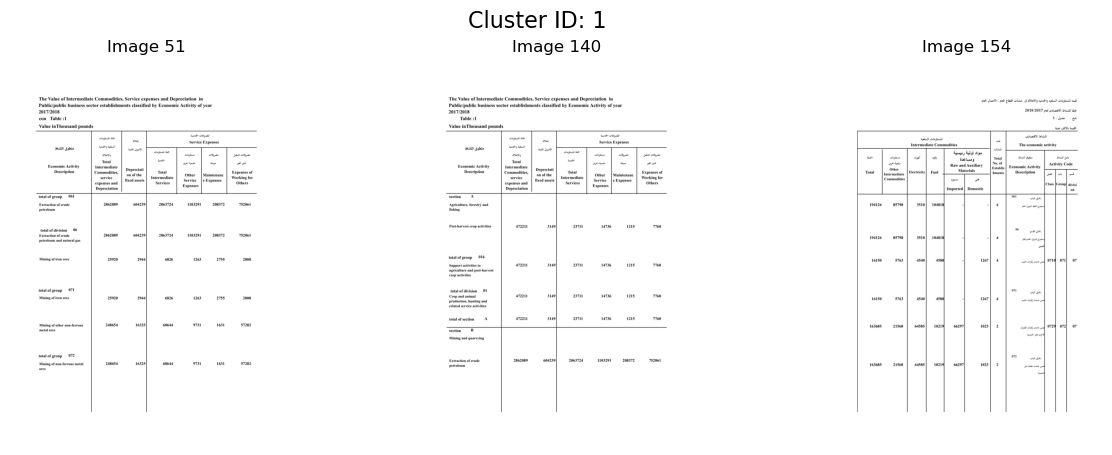

----------------------------------------------------------------------------------------------------
Cluster id: 5
Cluster size: 41
Sample Images in this Cluster:


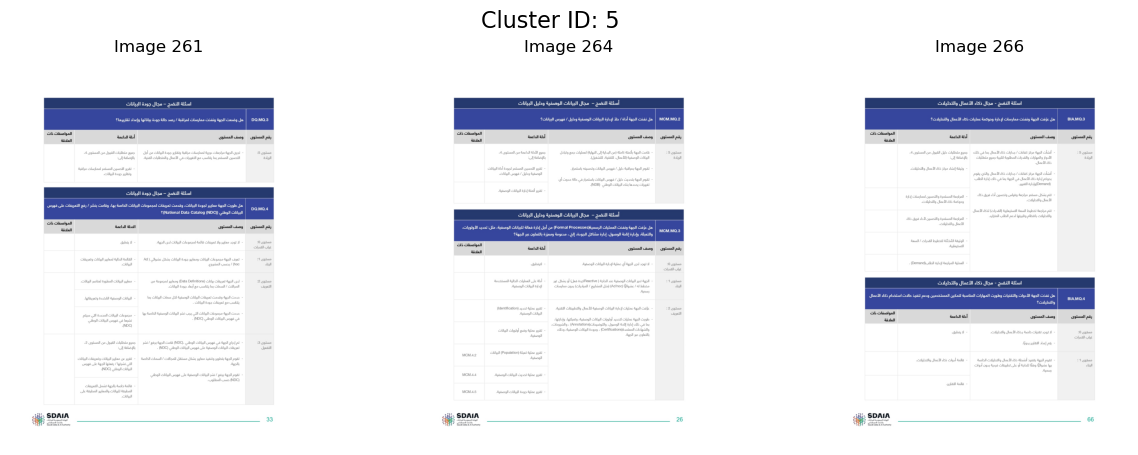

----------------------------------------------------------------------------------------------------
Cluster id: 3
Cluster size: 17
Sample Images in this Cluster:


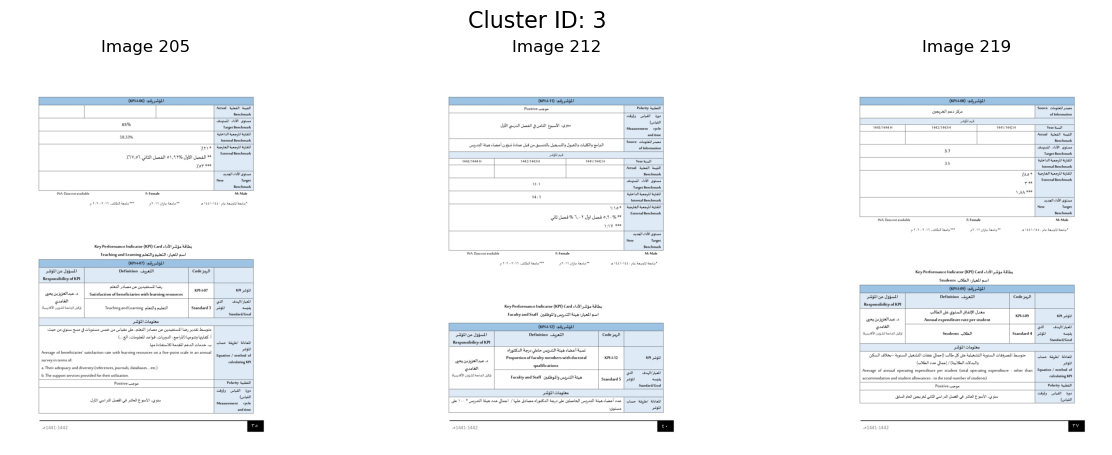

----------------------------------------------------------------------------------------------------
Cluster id: 0
Cluster size: 7
Sample Images in this Cluster:


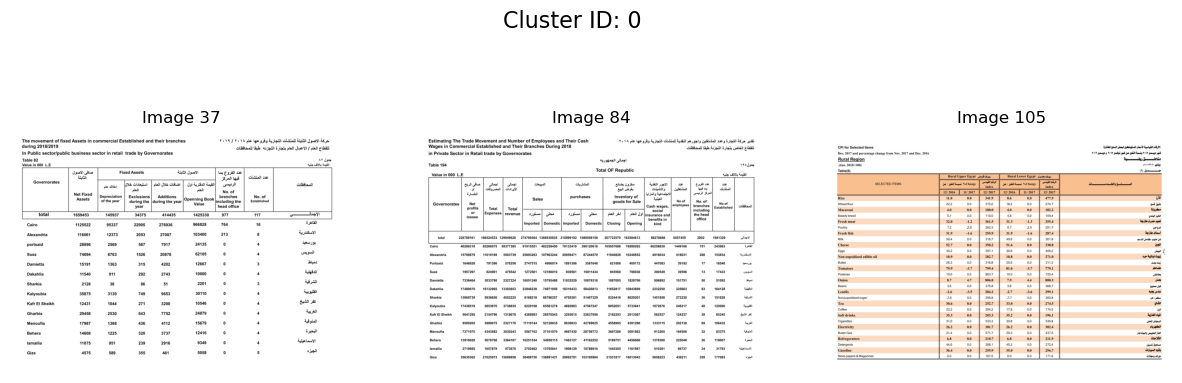

----------------------------------------------------------------------------------------------------
Cluster id: 13
Cluster size: 6
Sample Images in this Cluster:


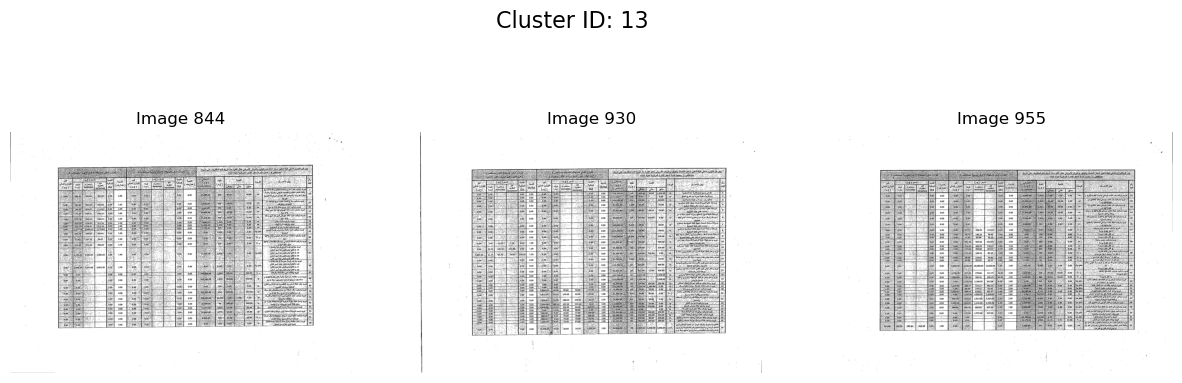

----------------------------------------------------------------------------------------------------
Cluster id: 2
Cluster size: 5
Sample Images in this Cluster:


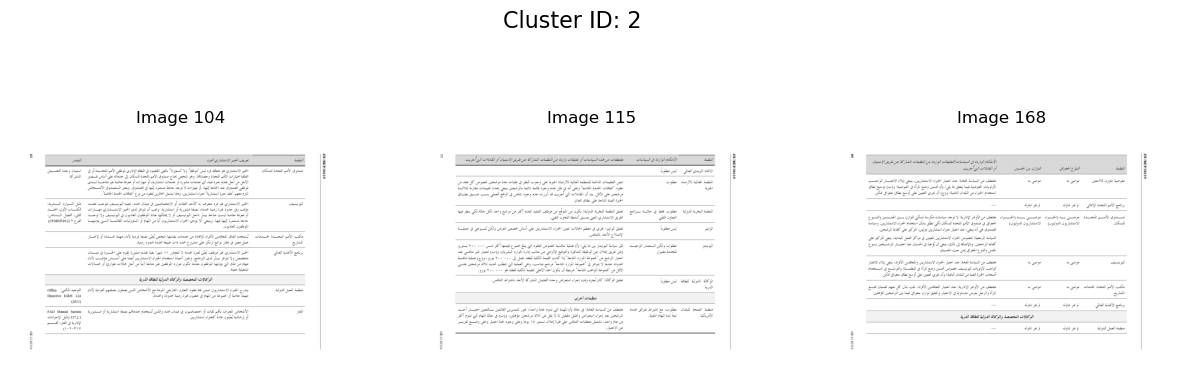

----------------------------------------------------------------------------------------------------
Cluster id: 12
Cluster size: 4
Sample Images in this Cluster:


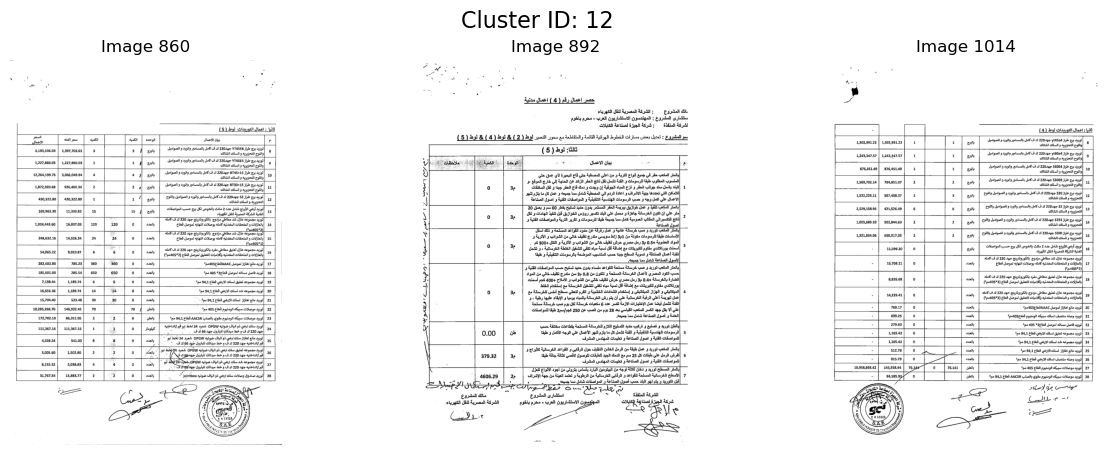

----------------------------------------------------------------------------------------------------
Cluster id: 10
Cluster size: 4
Sample Images in this Cluster:


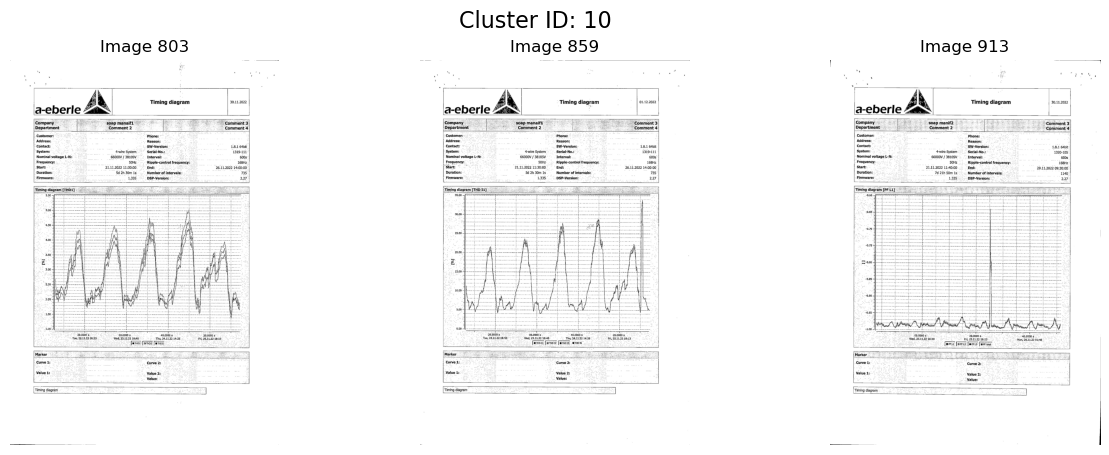

----------------------------------------------------------------------------------------------------
Cluster id: 8
Cluster size: 4
Sample Images in this Cluster:


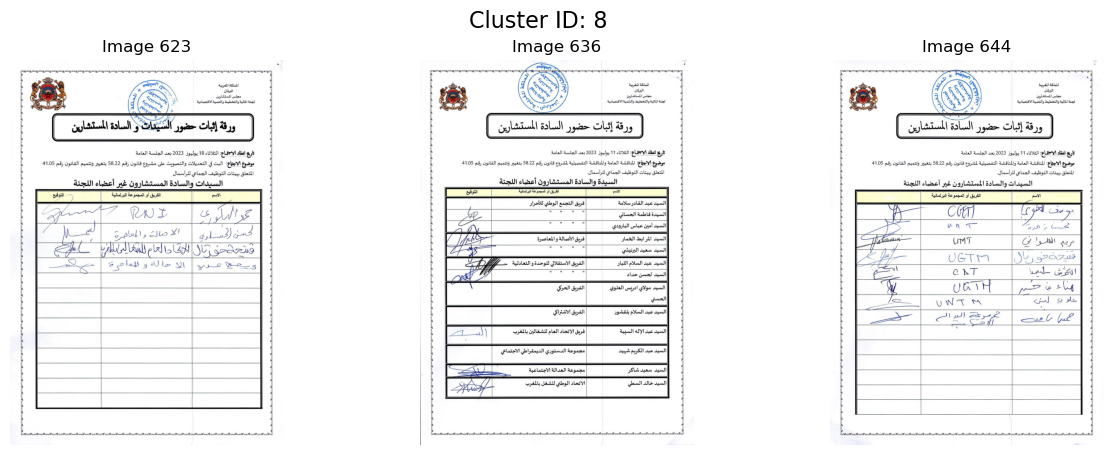

----------------------------------------------------------------------------------------------------


In [15]:
import matplotlib.pyplot as plt
import cv2  # For reading images

for i, l in enumerate(np.argsort(counts)[::-1][:10]):
    l -= 1
    if l == -1:
        continue
    
    cluster_ids = np.where(y == l)[0]
    print(f"Cluster id: {l}")
    print(f"Cluster size: {len(cluster_ids)}")
    
    # Display images
    print("Sample Images in this Cluster:")
    sample_indices = cluster_ids[:3]  # Adjust to 3 samples
    fig, axes = plt.subplots(1, len(sample_indices), figsize=(15, 5))
    
    for ax, idx in zip(axes, sample_indices):
        img_path = image_paths[idx]
        img_path = os.path.join("/home", img_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
        ax.imshow(img)
        ax.axis('off')  # Hide axis
        ax.set_title(f"Image {idx}")
    
    plt.suptitle(f"Cluster ID: {l}", fontsize=16)
    plt.show()
    print('-' * 100)


### Sampling

Apply the coreset algorithm, and show the results with t-SNE !

In [15]:
ids = coreset.sample(embeds)

Using previously computed dbscan_y
Initialize with 14 points



00%|██████████| 86/86 [00:00<00:00, 3896.37it/s]

[W] [15:22:04.102641] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


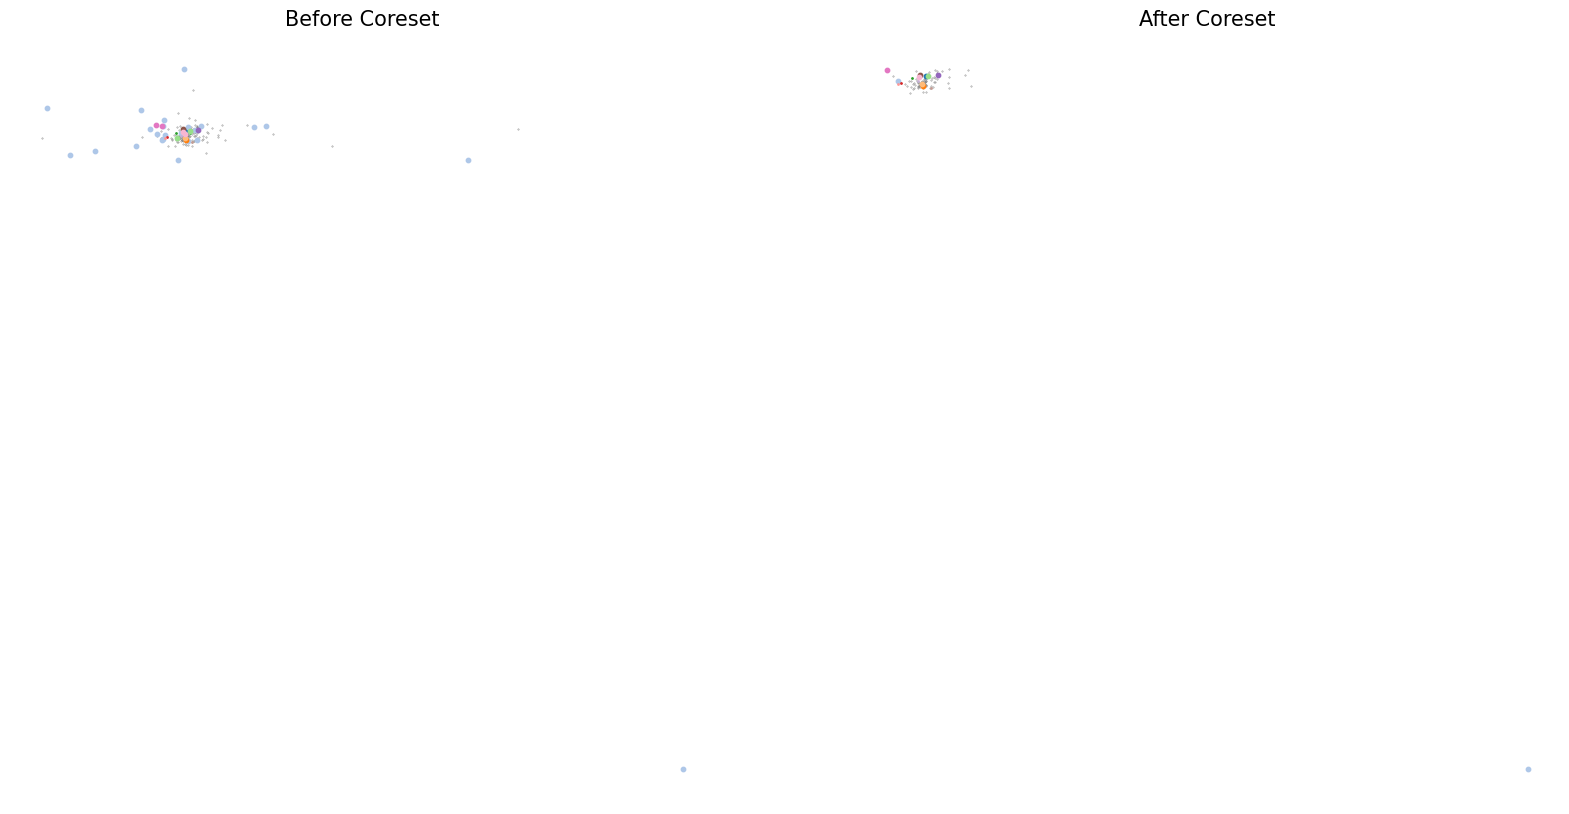

In [16]:
plot_coreset_results(
    embeds,
    y,
    counts,
    ids,
    min_size=MIN_SAMPLES,
    tsne_params=dict(perplexity=50, early_exaggeration=200),
)

In [28]:
import shutil
from pathlib import Path

# Given list of IDs

# Paths to saved image data
image_ids_file = "/home/Diversity-Sampling/image_ids.npy"
image_paths_file = "/home/Diversity-Sampling/image_paths.npy"

# Load the saved data
image_ids = np.load(image_ids_file)
image_paths = np.load(image_paths_file)

# Output directory
output_dir = Path("/home/Diversity-Sampling/sampled_images")
output_dir.mkdir(parents=True, exist_ok=True)

# Create a mapping of IDs to paths
id_to_path = dict(zip(image_ids, image_paths))

# Copy the files corresponding to the IDs in the list
for img_id in ids:
    # if img_id in id_to_path:
    src_path = image_paths[img_id]
    src_path = os.path.join("/home", src_path)
    # print(src_path)
    dest_path = output_dir / Path(src_path).name  # Preserve the original filename
    try:
        shutil.copy(src_path, dest_path)
        # print(f"Copied {src_path} to {dest_path}")
    except Exception as e:
        print(f"Failed to copy {src_path}: {e}")
    # else:
    #     print(f"ID {img_id} not found in the dataset.")


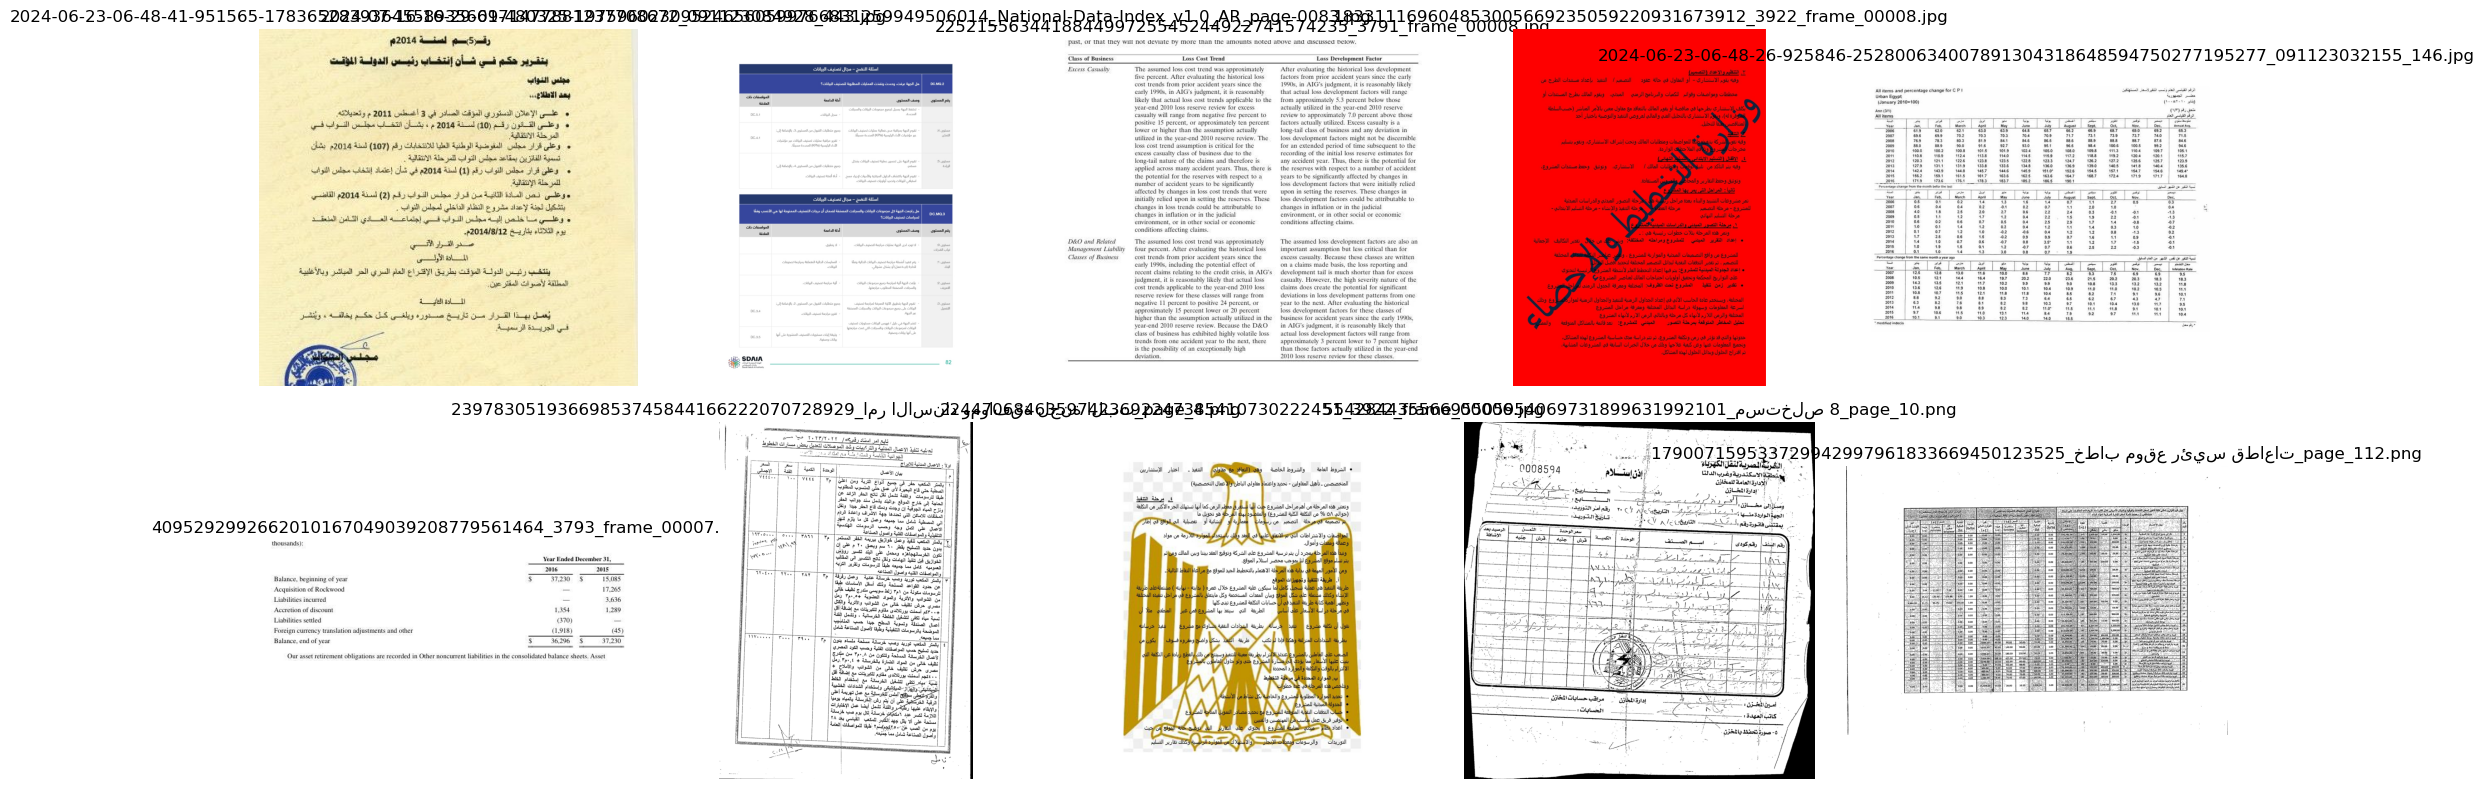

In [31]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def plot_random_images(directory, num_images=10):
    # Get a list of all image files in the directory
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(valid_extensions)]
    
    # Ensure there are enough images
    if len(image_files) < num_images:
        print(f"Not enough images in the directory. Found {len(image_files)} images.")
        num_images = len(image_files)
    
    # Randomly select images
    selected_images = random.sample(image_files, num_images)
    
    # Calculate rows and columns
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division for rows
    
    # Plot the selected images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
    axes = axes.flatten()  # Flatten axes for easier iteration
    
    for ax, img_path in zip(axes, selected_images):
        # Read the image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
        
        # Plot the image
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(img_path))  # Display the filename
    
    # Hide any unused axes
    for ax in axes[len(selected_images):]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Usage example
directory = "/home/Diversity-Sampling/sampled_images"  # Replace with your directory path
plot_random_images(directory)


## Compare with Random Sampling

To assess performance of the sampler, we provide two metrics that aim at demonstrating that the sampled data is more diverse than what you would get using random sampling.
The run the algorithm several times for more robustness, and do not use any initialization to save time.

- **Diversity**: We count the number of topics the sampled data contains and normalize it by its size. A higher value is better. The provided BERTopic classifier takes 2374 different values on our data.
- **KL Divergence**: Using a 10-class domain classifier, we aim at having a uniform sampling. This is assessed using the Kullback-Leibler divergence of the distribution of the sampled classes from the uniform distribution. A lower value is better.

In [21]:
N_TEXTS = [100, 500, 1000, 2000, 3000, 4000, 5000]  # Number of texts to sample

In [22]:
coreset = CoresetSampler(
    initialization="",
    dbscan_params={"eps": EPS, "min_samples": MIN_SAMPLES},
    tqdm_disable=True,
    verbose=0,
)

In [23]:
diversities_coreset = []
kl_divs_coreset = []
for n in N_TEXTS:
    diversities, kl_divs = [], []
    for _ in range(3):  # 3 -> 1 for faster execution
        sampled_ids = coreset.sample(embeds, n_samples=n)
        df_s = df.iloc[sampled_ids].reset_index(drop=True)
        
        # Diversity
        n_topics = len(df_s["bertopic_class"].unique())
        diversities.append(n_topics / n)

        # KL Div
        dist = df_s["domain"].value_counts().values / n
        unif = np.ones(len(dist)) / len(dist)
        kl_div = np.sum(dist * np.log(dist / unif))
        kl_divs.append(kl_div)

    div = np.mean(diversities)
    kl_div = np.mean(kl_divs)
    diversities_coreset.append(div)
    kl_divs_coreset.append(kl_div)
    print(f'- n={n} \t-  Diversity: {div:.3f}  -  KL Divergence {kl_div :.3f}')

- n=100 	-  Diversity: 0.980  -  KL Divergence 0.230
- n=500 	-  Diversity: 0.862  -  KL Divergence 0.242
- n=1000 	-  Diversity: 0.735  -  KL Divergence 0.287
- n=2000 	-  Diversity: 0.582  -  KL Divergence 0.297
- n=3000 	-  Diversity: 0.484  -  KL Divergence 0.307
- n=4000 	-  Diversity: 0.415  -  KL Divergence 0.302
- n=5000 	-  Diversity: 0.359  -  KL Divergence 0.319


In [24]:
diversities_random = []
kl_divs_random = []
for n in N_TEXTS:
    diversities = []
    kl_divs = []
    for _ in range(10):
        df_s = df.sample(n).reset_index(drop=True)
        
        # Diversity
        n_topics = len(df_s["bertopic_class"].unique())
        diversities.append(n_topics / n)
                
        # KL Div
        dist = df_s["domain"].value_counts().values / n
        unif = np.ones(len(dist)) / len(dist)
        kl_div = np.sum(dist * np.log(dist / unif))
        kl_divs.append(kl_div)

    div = np.mean(diversities)
    kl_div = np.mean(kl_divs)
    diversities_random.append(div)
    kl_divs_random.append(kl_div)
    print(f'- n={n} \t-  Diversity: {div:.3f}  - KL Divergence {kl_div :.3f}')

- n=100 	-  Diversity: 0.889  - KL Divergence 0.293
- n=500 	-  Diversity: 0.669  - KL Divergence 0.381
- n=1000 	-  Diversity: 0.545  - KL Divergence 0.378
- n=2000 	-  Diversity: 0.412  - KL Divergence 0.420
- n=3000 	-  Diversity: 0.338  - KL Divergence 0.452
- n=4000 	-  Diversity: 0.291  - KL Divergence 0.461
- n=5000 	-  Diversity: 0.259  - KL Divergence 0.444


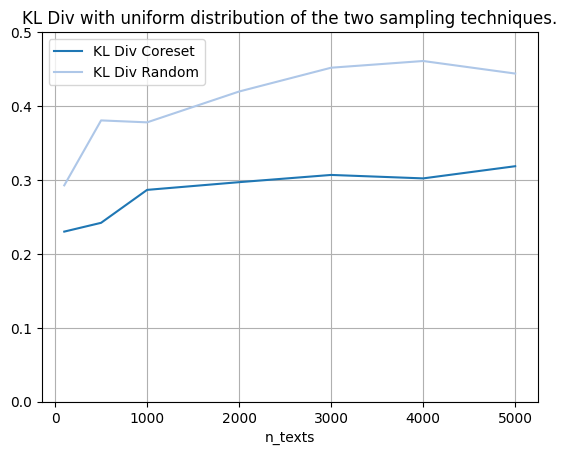

In [25]:
plt.plot(N_TEXTS, kl_divs_coreset, label="KL Div Coreset")
plt.plot(N_TEXTS, kl_divs_random, label="KL Div Random")
plt.xlabel('n_texts')
plt.legend()
plt.ylim(0, 0.5)
plt.grid()
plt.title('KL Div with uniform distribution of the two sampling techniques.')
plt.show()

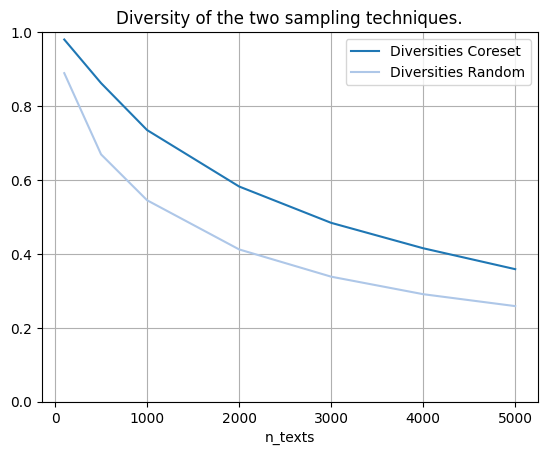

In [26]:
plt.plot(N_TEXTS, diversities_coreset, label="Diversities Coreset")
plt.plot(N_TEXTS, diversities_random, label="Diversities Random")
plt.xlabel('n_texts')
plt.legend()
plt.ylim(0, 1)
plt.grid()
plt.title('Diversity of the two sampling techniques.')
plt.show()

The metrics show that the sampled texts better captures the diversity of our dataset than random sampling, and are less biased by topic imbalance.

This is useful if your goal is to use a subset of wikipedia articles to finetune models.
A dataset sampled with coreset will provide more robustness for evaluation and more diversity of training.